In [63]:
import os.path as os
import cv2 as cv
import matplotlib.pyplot as plt
'''화상데이터_어노테이션데이터_파일경로 생성'''

'화상데이터_어노테이션데이터_파일경로 생성'

In [64]:
def make_datapath_list(rootpath:str):
    '''
    데이터 경로를 저장한 리스트 작성

    Parameters
    ----------

    rootpath: str
        데이터 폴더 경로
        
    Returns
    ----------
    ret: train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 저장한 리스트
    '''

    # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template=os.join(rootpath + 'JPEGImages', '%s.jpg')
    annopath_template=os.join(rootpath + 'Annotations', '%s.xml')

    # 훈련 및 검증 파일 ID(파일 이름) 취득
    train_id_names=os.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names=os.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip() # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id) # 화상 경로
        anno_path = (annopath_template % file_id) # 어노테이션 경로
        train_img_list.append(img_path) # 리스트에 화상경로 추가
        train_anno_list.append(anno_path) # 리스트에 어노테이션 경로 추가\

    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path= (imgpath_template % file_id)
        anno_path= (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [65]:
rootpath='C:/Users/hyssk/Myopencv/DeepLearningVision/SSD/data/'
train_img_list, train_anno_list, val_img_list, val_anno_list=make_datapath_list(rootpath=rootpath)
print(train_img_list[0])


C:/Users/hyssk/Myopencv/DeepLearningVision/SSD/data/JPEGImages\2008_000008.jpg


In [66]:
'''XML 형식의 어노테이션 데이터를 리스트로 변환하기'''
import xml.etree.ElementTree as ET
import numpy as np

In [67]:
class Anno_xml2list(object):
    '''
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
    
    Attributes
    ----------
    classes: 리스트
        VOC의 클래스명을 저장한 리스트
    '''

    def __init__(self, classes):
        self.classes=classes
    
    def __call__(self,xml_path,width,height):
        '''
        한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환

        Parameters
        ----------
        xml_path: str
            xml 파일 경로
        width: int
            대상 화상 폭
        height: int
            대상 화상 높이
        
        Returns
        ----------
        ret : [[xmin,ymin,xmax,ymax,label_ind],...]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만큼의 요소를 가진다.
        '''
        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장
        ret=[]

        # xml 파일 로드
        xml = ET.parse(xml_path).getroot()
        # 화상 내 물체(object) 수만큼 반복
        for obj in xml.iter('object'):
            # 어노테이션에서 검지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox=[]
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox') # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고 0~1으로 규격화
            pts = ['xmin','ymin','xmax','ymax']

            for pt in (pts):
                # VOC는 원점이 (1,1)이므로 1을 빼서 (0,0) 으로 한다.
                cur_pixel=int(bbox.find(pt).text) - 1
                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel/=width
                
                else:  # y 방향의 경우 높이로 나눈다.
                    cur_pixel /= height
                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            ret+=[bndbox]
        return np.array(ret)

In [68]:
voc_classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow',
             'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa',
             'train','tvmonitor']

transform_anno=Anno_xml2list(voc_classes)
image_file_path=train_img_list[0]
img=cv.imread(image_file_path)
height,width,channels=img.shape # [높이][폭][색BGR(채널)]
print(train_anno_list[0]) # 화상 크기 취득
transform_anno(train_anno_list[0],width,height)

C:/Users/hyssk/Myopencv/DeepLearningVision/SSD/data/Annotations\2008_000008.xml


array([[ 0.104     ,  0.19457014,  0.94      ,  0.9479638 , 12.        ],
       [ 0.314     ,  0.09728507,  0.576     ,  0.37556561, 14.        ]])

In [69]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort,Expand,RandomSampleCrop, RandomMirror,ToPercentCoords,Resize,SubtractMeans
'''util 폴더는 github.com/YutaroOgawa 에서 가져왔습니다.
    입력 영상의 전처리 클래스
'''

class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스, 훈련과 추론에서 다르게 작동
    화상 크기를 300*300으로 해야한다.
    학습 시 데이터 데이터 확장을 수행한다.

    Attributes 
    ----------
    input_size: int
        리사이즈 대상 화상의 크기
    color_mean: (B,G,R)
        각 색상 채널의 평균값
    """

    def __init__(self,input_size,color_mean):
        self.data_transform = {
            'train':Compose([
                ConvertFromInts(), # int를 Float32로 변환
                ToAbsoluteCoords(), # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(), # 화상의 색조 등 임의로 변환
                Expand(color_mean),# 화상의 캔버스 확대
                RandomSampleCrop(), # 화상 내의 특정 부분 무작위 추출
                RandomMirror(), # 화상 반전
                ToPercentCoords(), # 어노테이션 데이터를 0~1로 규격화
                Resize(input_size), # 화상 크기를 input_size * input_size로 변형
                SubtractMeans(color_mean) # BGR 색상의 평균값 빼기
            ]),
            'val': Compose([
                ConvertFromInts(), #int를 float로 변환
                Resize(input_size), # 화상 크기를 input_size * input_size로 변형
                SubtractMeans(color_mean) # BGR 색상의 평균값 빼기
            ])
        }
    def __call__(self,img,phase,boxes,labels): # 클래스 객체를 부르면 return 함
        '''
        Parameters
        ----------
        phase: 'train' or 'val'
            전처리 모드 지정
        '''
        return self.data_transform[phase](img,boxes,labels)

width: 500
height: 442


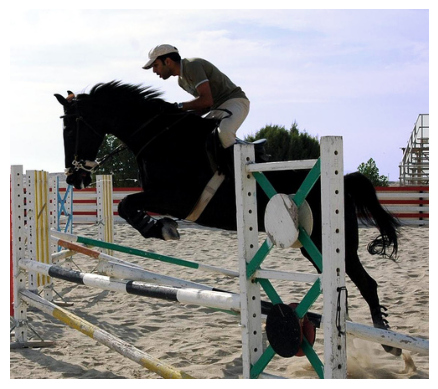

c:\Users\hyssk\Myopencv\DeepLearningVision\SSD\utils\data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


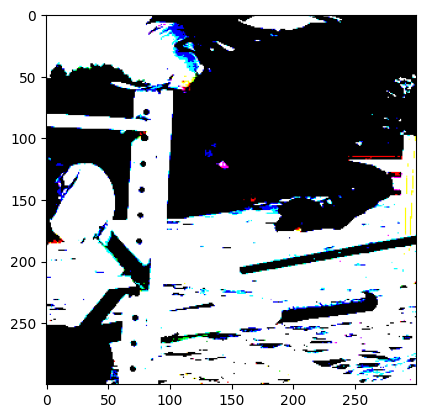

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


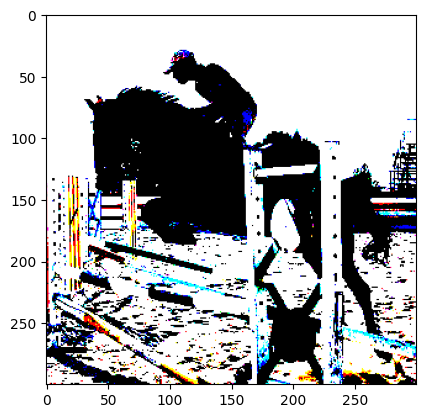

In [70]:
# 1. 화상 읽기
image_file_path=train_img_list[0]
img=cv.imread(image_file_path) # [높이][폭][색BGR]
height,width,channels=img.shape # 화상 크기 취득
print(f'width: {width}')
print(f'height: {height}')
# 2. 어노테이션을 리스트로 
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0],width,height) 

# 3. 원본 표시
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.axis(False)
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104,117,123) # (BGR) 색상의 평균값
input_size = 300 # 화상의 input_size를 300*300
transform = DataTransform(input_size=input_size, color_mean=color_mean) # 클래스 객체 생성

# 5. Train 화상 표시
phase = 'train'
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:,4])
plt.imshow(cv.cvtColor(img_transformed,cv.COLOR_BGR2RGB))
plt.show()
# 6. Val 화상 표시
phase = 'val'
img_transformed, boxes, labels = transform(img, phase, anno_list[:,:4],anno_list[:,4])
plt.imshow(cv.cvtColor(img_transformed,cv.COLOR_BGR2RGB))
plt.show()

In [73]:
'''데이터셋 작성'''
from torch.utils.data import Dataset
import torch

In [76]:
class VOCDataset(Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. 파이토치의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    img_list: 리스트
        화상경로를 저장한 리스트
    anno_list: 리스트
        어노테이션 경로를 저장한 리스트
    phase: 'train' or 'val'
        학습 또는 훈련 설정
    transform: object
        전처리 클래스의 인스턴스
    transform_anno: object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """
    def __init__(self,img_list,anno_list,phase,transform,transform_anno):
        self.img_list = img_list
        self.anno_list= anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno=transform_anno

    def __len__(self):
        '''화상의 매수 반환'''
        return len(self.img_list)
    
    def __getitem__(self,index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션 획득
        '''
        im,gt,h,w=self.pull_item(index)
        return im,gt
    
    def pull_item(self,index):
        '''전터리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득'''
        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv.imread(image_file_path) #[높이][너비][색BGR]
        height,width,channels=img.shape # 화상 크기 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path,width,height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img,self.phase,anno_list[:,:4],anno_list[:,4]
        )
        # 색상 채널의 순서가 BGR 이므로 RGB로 변경
        img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)

        # BBOX와 라벨을 세트로 한 np.array를 작성. 변수 이름 gt는 ground truth의 약칭
        gt = np.hstack((boxes,np.expand_dims(labels,axis=1)))

        return img, gt, height, width

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5823


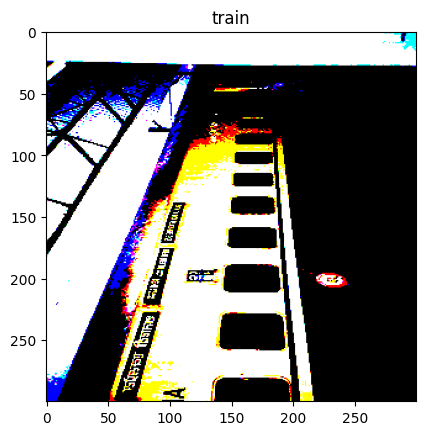

In [93]:
color_mean = (104,117,123) # (BGR) 색상의 평균값
input_size = 300 # 화상의 input_size를 300*300
train_dataset=VOCDataset(train_img_list,
                          train_anno_list,
                          phase='train',
                          transform=DataTransform(input_size,color_mean),
                          transform_anno=Anno_xml2list(voc_classes))

val_dataset=VOCDataset(val_img_list,
                       anno_list=val_anno_list,
                       phase='val',
                       transform=DataTransform(input_size,color_mean),
                       transform_anno=Anno_xml2list(voc_classes))
plt.imshow(val_dataset.__getitem__(1)[0].permute(2,1,0))
plt.title(voc_classes[int(val_dataset.__getitem__(1)[1][:,4][0])])

print(len(val_dataset))